<a href="https://colab.research.google.com/github/nishant-5/rossman/blob/main/Rossmann_Sales_Prediction_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Random Forest Hyperparameter Tuning

##Importing important libraries and modules

In [1]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':100})
from datetime import datetime

#import warnings
import warnings    
warnings.filterwarnings('ignore')

#metrics import
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#importing model 
from sklearn.ensemble import RandomForestRegressor

##Reading Data

In [3]:
df2 = pd.read_csv("/content/clean_data.csv",parse_dates=['Date'])
comparison_df = pd.read_csv("/content/result.csv")

In [4]:
#setting date and store as index
df2.set_index(['Date','Store'],inplace=True)

df2.sort_index(inplace=True)

In [5]:
comparison_df.drop('Unnamed: 0',axis=1,inplace=True)
comparison_df

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,Decision Tree Regressor,0.003878,0.003312,0.057546,0.996688,0.996688,0.351895,0.259711,0.509618,0.724290,0.724134
1,Random Forest Regressor,0.084074,0.016638,0.128990,0.983362,0.983361,0.270870,0.142357,0.377302,0.848874,0.848788


In [6]:
df2.head(1)

,,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,WeekOfYear,DayOfYear,CompetitionOpen,Promo2Open,Promo2running
Date,Store,,,,,,,,,,,,,,,,,
2013-01-01,85,2,8.34759,619,0,1.0,1,b,a,1870.0,0,2013,1,1,1,15.0,0.0,0


In [7]:
#slicing the most recent six weeks and creating train and test set
#train
start_train = pd.to_datetime("2013-01-01")
end_train = pd.to_datetime("2015-06-14")
df_train = df2.loc[start_train:end_train]
#test
start_test = pd.to_datetime("2015-06-15")
end_test = pd.to_datetime("2015-07-31")
df_test = df2.loc[start_test:end_test]

In [8]:
#X and y split for train and test
X_train = df_train.drop('Sales',axis=1)
y_train = df_train[['Sales']]
X_test = df_test.drop('Sales',axis=1)
y_test = df_test[['Sales']]
print(f'The shape of X_train is: {X_train.shape}')
print(f'The shape of y_train is: {y_train.shape}')
print(f'The shape of X_test is: {X_test.shape}')
print(f'The shape of y_test is: {y_test.shape}')

The shape of X_train is: (798486, 16)
The shape of y_train is: (798486, 1)
The shape of X_test is: (45852, 16)
The shape of y_test is: (45852, 1)


In [13]:
#importing
from sklearn.preprocessing import OneHotEncoder
#categorical features
categorical_cols = ['DayOfWeek', 'StoreType', 'Assortment']
#fit encoder
encoder = OneHotEncoder(sparse=False)
# train
encoder.fit(X_train[categorical_cols])
encoded_features = list(encoder.get_feature_names(categorical_cols))
X_train[encoded_features] = encoder.transform(X_train[categorical_cols])
# test
X_test[encoded_features] = encoder.transform(X_test[categorical_cols])
# drop original features
X_train.drop(categorical_cols,axis=1,inplace=True)
X_test.drop(categorical_cols,axis=1,inplace=True)

In [14]:
# scaling
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train[list(X_train.columns)] = stdsc.fit_transform(X_train[list(X_train.columns)])
X_test[list(X_test.columns)] = stdsc.transform(X_test[list(X_test.columns)])

scaler = StandardScaler()
y_train[list(y_train.columns)] = scaler.fit_transform(y_train[list(y_train.columns)])
y_test[list(y_test.columns)] = scaler.transform(y_test[list(y_train.columns)])

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 798486 entries, (Timestamp('2013-01-01 00:00:00'), 85) to (Timestamp('2015-06-14 00:00:00'), 1099)
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Customers            798486 non-null  float64
 1   Promo                798486 non-null  float64
 2   StateHoliday         798486 non-null  float64
 3   SchoolHoliday        798486 non-null  float64
 4   CompetitionDistance  798486 non-null  float64
 5   Promo2               798486 non-null  float64
 6   Year                 798486 non-null  float64
 7   Month                798486 non-null  float64
 8   WeekOfYear           798486 non-null  float64
 9   DayOfYear            798486 non-null  float64
 10  CompetitionOpen      798486 non-null  float64
 11  Promo2Open           798486 non-null  float64
 12  Promo2running        798486 non-null  float64
 13  DayOfWeek_1          798486 non-null  float64
 1

In [16]:
# Create model
rf_tuned = RandomForestRegressor()

In [17]:
#import
from sklearn.model_selection import RandomizedSearchCV
#grid
random_grid = {'bootstrap': [True, False],
 'max_depth': [ 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 8],
 'n_estimators': [100, 130, 150]}

rf_random = RandomizedSearchCV(estimator = rf_tuned, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42)

#fitting
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time= 6.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time= 6.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time= 6.5min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 8.4min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 8.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 8.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimato

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 8],
                                        'n_estimators': [100, 130, 150]},
                   random_state=42, verbose=2)

In [18]:
#best para
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [19]:
#save the best parameters
random_t = rf_random.best_estimator_

In [20]:
#Columns needed to compare metrics
comparison_columns = ['Model_Name', 'Train_MAE', 'Train_MSE', 'Train_RMSE', 'Train_R2', 'Train_Adj_R2' ,'Test_MAE', 'Test_MSE', 'Test_RMSE', 'Test_R2', 'Test_Adj_R2']

In [21]:
#function to evaluate the model
def model_evaluation(model_name,model_variable,X_train,y_train,X_test,y_test):
  ''' This function predicts and evaluates various models for regression algorithms, visualizes results 
      and creates a dataframe that compares the various models.'''
      
  #making predictions
  y_pred_train = model_variable.predict(X_train)
  y_pred_test = model_variable.predict(X_test)

  # Plot the test results
  a = y_test.copy()
  a['Pred Sales'] = y_pred_test.tolist()
  df_plot = a.reset_index(level=['Date'])
  plot = df_plot.groupby('Date')['Sales','Pred Sales'].sum()
  sns.lineplot(data = plot)
  plt.ylabel("Total Sales and Predicted Sales")
  plt.xticks(rotation = 25)

  #calculate metrics and print the results for test set
  #Mean Absolute Error or MAE
  MAE_train = round(mean_absolute_error(y_train,y_pred_train),6)
  MAE_test = round(mean_absolute_error(y_test,y_pred_test),6)
  #Mean Squared Error or MSE
  MSE_train = round(mean_squared_error(y_train,y_pred_train),6)
  MSE_test = round(mean_squared_error(y_test,y_pred_test),6)
  #Root Mean Squared Error or RMSE
  RMSE_train = round(mean_squared_error(y_train,y_pred_train,squared=False),6)
  RMSE_test = round(mean_squared_error(y_test,y_pred_test,squared=False),6)
  #R2
  R2_train = round(r2_score(y_train, y_pred_train),6)
  R2_test = round(r2_score(y_test, y_pred_test),6)
  #Adjusted R2
  Adj_r2_train = round(1 - (1-r2_score(y_train, y_pred_train)) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1),6)
  Adj_r2_test = round(1 - (1-r2_score(y_test, y_pred_test)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),6)

  #printing test results
  print(f'The Mean Absolute Error for the validation set is {MAE_test}')
  print(f'The Mean Squared Error for the validation set is {MSE_test}')
  print(f'The Root Mean Squared Error for the validation set is {RMSE_test}')
  print(f'The R^2 for the validation set is {R2_test}')
  print(f'The Adjusted R^2 for the validation set is {Adj_r2_test}')

  #Saving our results
  global comparison_columns
  metric_scores = [model_name,MAE_train,MSE_train,RMSE_train,R2_train,Adj_r2_train,MAE_test,MSE_test,RMSE_test,R2_test,Adj_r2_test]
  final_dict = dict(zip(comparison_columns,metric_scores))
  return [final_dict]

The Mean Absolute Error for the validation set is 0.142657
The Mean Squared Error for the validation set is 0.036235
The Root Mean Squared Error for the validation set is 0.190354
The R^2 for the validation set is 0.961533
The Adjusted R^2 for the validation set is 0.961511


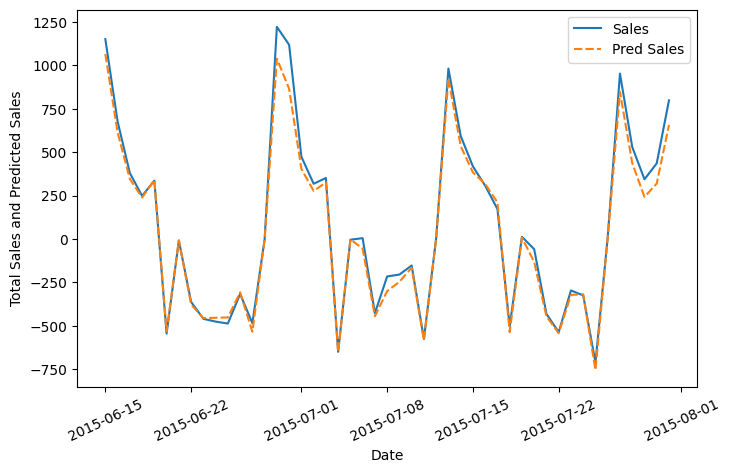

In [22]:
#evaluate tuned model
random_tuned = model_evaluation('Random Forest Tuned',random_t,X_train,y_train,X_test,y_test)

In [23]:
#add to comparison_df
comparison_df = comparison_df.append(random_tuned)

In [24]:
#comparison_df
comparison_df

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,Decision Tree Regressor,0.003878,0.003312,0.057546,0.996688,0.996688,0.351895,0.259711,0.509618,0.724290,0.724134
1,Random Forest Regressor,0.084074,0.016638,0.128990,0.983362,0.983361,0.270870,0.142357,0.377302,0.848874,0.848788
0,Random Forest Tuned,0.043276,0.003496,0.059124,0.996504,0.996504,0.142657,0.036235,0.190354,0.961533,0.961511


####Feature Importance

###Model Performance and Evaluation

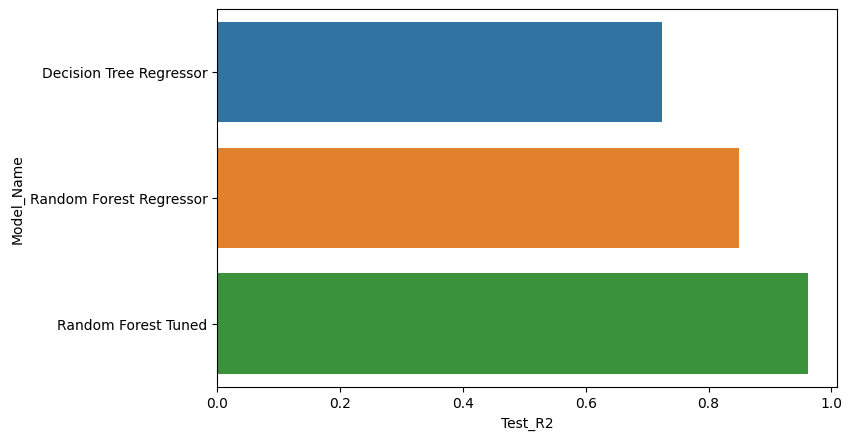

In [25]:
#visualising our comparison df for Test R2
sns.barplot(y=comparison_df['Model_Name'], x = comparison_df['Test_R2'])

####Random Forest vs Baseline Model

In [26]:
#test values
baseline_r2 = 0.724134
random_r2 = 0.848788
r_tuned_r2 = 0.961511

In [27]:
#improvement % 
improvement_r = ((random_r2 - baseline_r2)/baseline_r2)*100
print('Model Performance')
print(f'Improvement of {round(improvement_r,3)} % was seen in Random Forest against Decision Tree.')

Model Performance
Improvement of 17.214 % was seen in Random Forest against Decision Tree.


###Store wise Sales Predictions

In [28]:
#predictions 
y_pred_test = random_t.predict(X_test)
six_weeks_sales_df = y_test.copy()
six_weeks_sales_df['Pred_Sales'] = y_pred_test.tolist()

In [29]:
#head
six_weeks_sales_df.head()

Sales  Pred_Sales
Date       Store                      
2015-06-15 1     -0.328664   -0.454044
           2      0.574378    0.543755
           3      1.252047    1.353793
           4      1.572145    1.443417
           5      0.486429    0.454133

Completed again